# Experiment 3
Including Only Labeled Samples

## Dataset

In [1]:
import os
import sys

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
ROOT_DIR = os.getcwd()
sys.path.insert(0, ROOT_DIR)

In [3]:
def combine_dataframes(df_classes, df_features, only_labeled=True):
    df_combined = pd.merge(
        df_features, df_classes, left_on="id", right_on="txId", how="left"
    )
    if only_labeled == True:
        df_combined = df_combined[df_combined["class"] != 2].reset_index(drop=True)
    df_combined.drop(columns=["txId"], inplace=True)
    return df_combined

In [4]:
def rename_classes(df_classes):
    df_classes.replace({"class": {"1": 1, "2": 0, "unknown": 2}}, inplace=True)
    return df_classes

In [5]:
def rename_features(df_features):
    df_features.columns = (
        ["id", "time_step"]
        + [f"trans_feat_{i}" for i in range(93)]
        + [f"agg_feat_{i}" for i in range(72)]
    )
    return df_features

In [6]:
def import_elliptic_data_from_csvs():
    df_classes = pd.read_csv(
        os.path.join(ROOT_DIR, "datasets/elliptic/elliptic_txs_classes.csv")
    )
    df_edges = pd.read_csv(
        os.path.join(ROOT_DIR, "datasets/elliptic/elliptic_txs_edgelist.csv")
    )
    df_features = pd.read_csv(
        os.path.join(ROOT_DIR, "datasets/elliptic/elliptic_txs_features.csv"),
        header=None,
    )
    return df_classes, df_edges, df_features

In [7]:
def setup_train_test_idx(
    X, last_train_time_step, last_time_step, aggregated_timestamp_column="time_step"
):
    """The aggregated_time_step_column needs to be a column with integer values, such as year, month or day"""

    split_timesteps = {}

    split_timesteps["train"] = list(range(last_train_time_step + 1))
    split_timesteps["test"] = list(range(last_train_time_step + 1, last_time_step + 1))

    train_test_idx = {}
    train_test_idx["train"] = X[
        X[aggregated_timestamp_column].isin(split_timesteps["train"])
    ].index
    train_test_idx["test"] = X[
        X[aggregated_timestamp_column].isin(split_timesteps["test"])
    ].index

    return train_test_idx

In [8]:
def train_test_split(X, y, train_test_idx):
    X_train_df = X.loc[train_test_idx["train"]]
    X_test_df = X.loc[train_test_idx["test"]]

    y_train = y.loc[train_test_idx["train"]]
    y_test = y.loc[train_test_idx["test"]]

    return X_train_df, X_test_df, y_train, y_test

In [9]:
def load_elliptic_data(only_labeled=True, drop_node_id=True):
    df_classes, df_edges, df_features = import_elliptic_data_from_csvs()
    df_features = rename_features(df_features)
    df_classes = rename_classes(df_classes)
    df_combined = combine_dataframes(df_classes, df_features, only_labeled)

    if drop_node_id == True:
        X = df_combined.drop(columns=["id", "class"])
    else:
        X = df_combined.drop(columns="class")

    y = df_combined["class"]

    return X, y

In [10]:
def run_elliptic_preprocessing_pipeline(
    last_train_time_step, last_time_step, only_labeled=True, drop_node_id=True
):
    X, y = load_elliptic_data(only_labeled, drop_node_id)
    train_test_idx = setup_train_test_idx(X, last_train_time_step, last_time_step)
    X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, train_test_idx)

    return X_train_df, X_test_df, y_train, y_test

## EFC

In [119]:
from efc import EnergyBasedFlowClassifier

In [120]:
# Elliptic data set timestep
last_time_step = 49
last_train_time_step = 34
only_labeled = True

In [121]:
X_train_df, X_test_df, y_train, y_test = run_elliptic_preprocessing_pipeline(
    last_train_time_step=last_train_time_step,
    last_time_step=last_time_step,
    only_labeled=only_labeled,
)

/var/folders/8b/c9dvlw851kx2vf3r7gc5gbbh0000gn/T/ipykernel_57958/3533226547.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_classes.replace({"class": {"1": 1, "2": 0, "unknown": 2}}, inplace=True)


In [122]:
# X_train_df.drop(columns=[f"agg_feat_{i}" for i in range(72)], axis=1, inplace=True)

In [123]:
#X_test_df.drop(columns=[f"agg_feat_{i}" for i in range(72)], axis=1, inplace=True)

In [124]:
#y_train.drop(columns=[f"agg_feat_{i}" for i in range(72)], axis=1, inplace=True)

In [125]:
#y_test.drop(columns=[f"agg_feat_{i}" for i in range(72)], axis=1, inplace=True)

In [126]:
results_efc = 'results/efc/experiment-3'

In [127]:
sizes = {
    "X Size": len(X_train_df) + len(X_test_df),
    "y Size": len(y_train) + len(y_test),
    "X_train Size": len(X_train_df),
    "X_test Size": len(X_test_df),
    "y_train Size": len(y_train),
    "y_test Size": len(y_test),
    "y_train Malicious Size": len(np.where(y_train == 1)[0]),
    "y_train Bening Size": len(np.where(y_train == 0)[0]),
    "y_test Malicious Size": len(np.where(y_test == 1)[0]),
    "y_test Bening Size": len(np.where(y_test == 0)[0]),
}

In [128]:
df_sizes = pd.DataFrame(data=sizes, index=[0])

In [129]:
df_sizes

,X Size,y Size,X_train Size,X_test Size,y_train Size,y_test Size,y_train Malicious Size,y_train Bening Size,y_test Malicious Size,y_test Bening Size
0,46564,46564,29894,16670,29894,16670,3462,26432,1083,15587


In [130]:
clf = EnergyBasedFlowClassifier(n_bins=20, cutoff_quantile=0.9, pseudocounts=0.1)

In [131]:
clf.fit(X_train_df, y_train)

EnergyBasedFlowClassifier(cutoff_quantile=0.9, n_bins=20, pseudocounts=0.1)

In [132]:
y_pred, y_energies = clf.predict(X_test_df, return_energies=True)

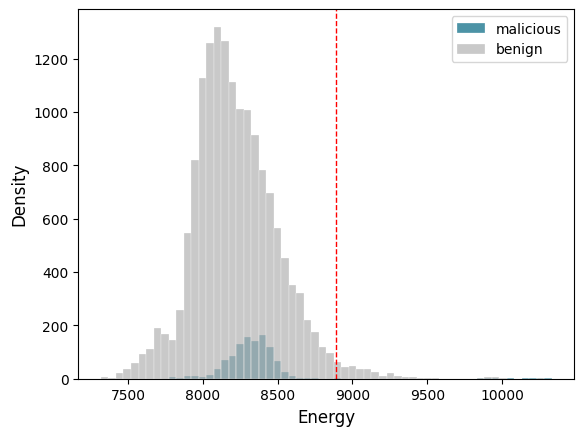

In [133]:
# ploting energies
benign = np.where(y_test == 0)[0]
malicious = np.where(y_test == 1)[0]

benign_energies = y_energies[benign]
malicious_energies = y_energies[malicious]
cutoff = clf.estimators_[0].cutoff_

bins = np.histogram(y_energies, bins=60)[1]

plt.hist(
    malicious_energies,
    bins,
    facecolor="#006680",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="malicious",
)
plt.hist(
    benign_energies,
    bins,
    facecolor="#b3b3b3",
    alpha=0.7,
    ec="white",
    linewidth=0.3,
    label="benign",
)
plt.axvline(cutoff, color="r", linestyle="dashed", linewidth=1)
plt.legend()

plt.xlabel("Energy", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.savefig(f'{results_efc}/1_labeled_samples.png')

In [134]:
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix
)

In [135]:
def calculate_model_score(y_true, y_pred):
    metric_dict = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred, average="weighted"),
        "f1_micro": f1_score(y_true, y_pred, average="micro"),
        "f1_macro": f1_score(y_true, y_pred, average="macro"),
        "precision": precision_score(y_true, y_pred, average="weighted"),
        "recall": recall_score(y_true, y_pred, average="weighted"),
    }
    return metric_dict

In [136]:
model_score = calculate_model_score(y_true=y_test.values, y_pred=y_pred)

In [137]:
model_score

{'accuracy': 0.9172165566886623,
 'f1': np.float64(0.896438691187951),
 'f1_micro': np.float64(0.9172165566886623),
 'f1_macro': np.float64(0.49246796568887),
 'precision': np.float64(0.8780338863735273),
 'recall': np.float64(0.9172165566886623)}

In [138]:
df_efc_metrics = pd.DataFrame(data=model_score, index=[0])

In [139]:
df_efc_metrics

,accuracy,f1,f1_micro,f1_macro,precision,recall
0,0.917217,0.896439,0.917217,0.492468,0.878034,0.917217


In [140]:
labels_cm = ["True Negative", "False positive", "False Negative", "True Positive"]

In [141]:
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])

In [142]:
cm = np.reshape(cm, -1).tolist()

In [143]:
cm

[20, 1063, 317, 15270]

In [144]:
confusion_matrix = {'Technique': 'All labeled samples'} | {label: val for val, label in zip(cm, labels_cm)}

In [145]:
confusion_matrix

{'Technique': 'All labeled samples',
 'True Negative': 20,
 'False positive': 1063,
 'False Negative': 317,
 'True Positive': 15270}

### Investigating f1_macro

In [34]:
f1_weighted = f1_score(y_true=y_test.values, y_pred=y_pred, average="weighted")

In [35]:
f1_weighted

np.float64(0.9023642297215495)

In [36]:
f1_micro = f1_score(y_true=y_test.values, y_pred=y_pred, average="micro")

In [37]:
f1_micro

np.float64(0.9320335932813437)

In [38]:
f1_macro = f1_score(y_true=y_test.values, y_pred=y_pred, average="macro")

In [39]:
f1_macro

np.float64(0.4841674862120687)

In [40]:
f1_pos_label = f1_score(y_true=y_test.values, y_pred=y_pred, pos_label=0)

In [41]:
f1_pos_label

np.float64(0.9648169425208831)

In [42]:
malicious_test = np.where(y_test == 1)[0]

In [43]:
len(malicious_test)

1083

In [44]:
malicious_pred = np.where(y_pred == 1)[0]

In [45]:
len(malicious_pred)

54

In [46]:
benign_test = np.where(y_test == 0)[0]

In [47]:
len(benign_test)

15587

In [48]:
benign_pred = np.where(y_pred == 0)[0]

In [49]:
len(benign_pred)

16616